In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
t = pd.read_csv("~/Desktop/test.csv")

In [3]:
t = np.array(t)[:,1:3]

In [4]:
t

array([[1.57255931e+09, 1.48558255e+10],
       [1.57256042e+09, 1.37260294e+10],
       [1.57256138e+09, 1.28394645e+10],
       ...,
       [1.57312613e+09, 1.86370550e+10],
       [1.57312631e+09, 1.85022212e+10],
       [1.57312649e+09, 1.94498533e+10]])

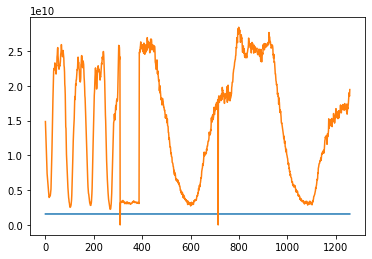

In [5]:
plt.plot(t)
plt.show()

In [6]:
t

array([[1.57255931e+09, 1.48558255e+10],
       [1.57256042e+09, 1.37260294e+10],
       [1.57256138e+09, 1.28394645e+10],
       ...,
       [1.57312613e+09, 1.86370550e+10],
       [1.57312631e+09, 1.85022212e+10],
       [1.57312649e+09, 1.94498533e+10]])

In [7]:
from datetime import datetime, timedelta
import logging
logger = logging.getLogger(__name__)
class Test:
    
    def get_first_of_month(self):
        """Get the first day of this month"""
        today = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
        first = "-".join(today.split("-")[:2]) + "-01-00:00:00"
        logger.debug("Today is %s the first of the month is %s", today, first)
        return datetime.fromisoformat(first)

    def get_seconds_from_first_of_month(self):
        """Return how many seconds have passed form the first of the month"""
        first = self.get_first_of_month()
        logger.debug(f"Today is {datetime.today()}")
        delta = datetime.today() - first
        return float(delta.total_seconds())

    def get_time_grid(self):
        """Return the array of timestamps from the 00:00 of the first of the month using steps of 5 minutes.
        e.g. [2019/10/01-00:00:00, 2019/10/01-00:05:00, 2019/10/01-00:10:00] but in timestamp.""" 
        start = self.get_first_of_month()
        # Rounding the values to the LAST multiple of 5 minutes. 18:28 will be rounded to 18:25
        n_of_points = int(self.get_seconds_from_first_of_month() / (5 * 60)) 
        return [
            datetime.timestamp(start + timedelta(minutes=20*i))
            for i in range(n_of_points)
        ]

    def get_closest_points(self, values, timestamp):
        """Find the two closest point to the timestamp, a[i-1] < v <= a[i]"""
        times = np.array([x[0] for x in values])
        # ASSUMPTION the values must be sorted, this should not be a problem since INFLUX should sort them for us
        # ASSUMPTION the value ar sorted from the smallest to the biggest
        # Chosen the left so a[i-1] < v <= a[i] so it can works if the point has the same timestamp of the analysis
        idx = np.searchsorted(times, timestamp, side="left")
        if idx <= 0:
            # IF the data it's the first, consider it starting from 0
            result = ((values[-1][0] - 5, 0), values[0])
        elif values[-1][0] < timestamp:
            # IF the timestamp is bigger than the last timestamp of the values
            result = (values[-1], (timestamp, 0))
        elif idx >= len(values):
            # IF recent data miss, consider it 0 because it might be off
            result = (values[-1], (timestamp, 0))
        else:
            # Else return the two values
            result = (values[idx - 1], values[idx])

        assert result[0][0] <= timestamp <= result[1][0], "ERROR IN INTERPOLATION"
        return result

    def interpolate(self, values, timestamp):
        """Linear inerpolation of the values https://en.wikipedia.org/wiki/Linear_interpolation"""
        t_0, v_0 = values[0][0], values[0][1]
        t_1, v_1 = values[1][0], values[1][1]
        result  = (v_0 * (t_1 - timestamp)) 
        result += (v_1 * (timestamp - t_0))
        result /= (t_1 - t_0)
        assert min(v_0,v_1) <= result <= max(v_0,v_1)
        return result

    def value_aligner(self, values):
        """Interpolate data so that we have aligned data at each 5 minutes"""
        time = self.get_time_grid()
        closest = [
            self.get_closest_points(values, t) for t in time
        ]
        return time, [
            self.interpolate(values, timestamp) for timestamp, values in zip(time, closest)
        ]


In [8]:
test = Test()

In [9]:
tb, ta = test.value_aligner(t)

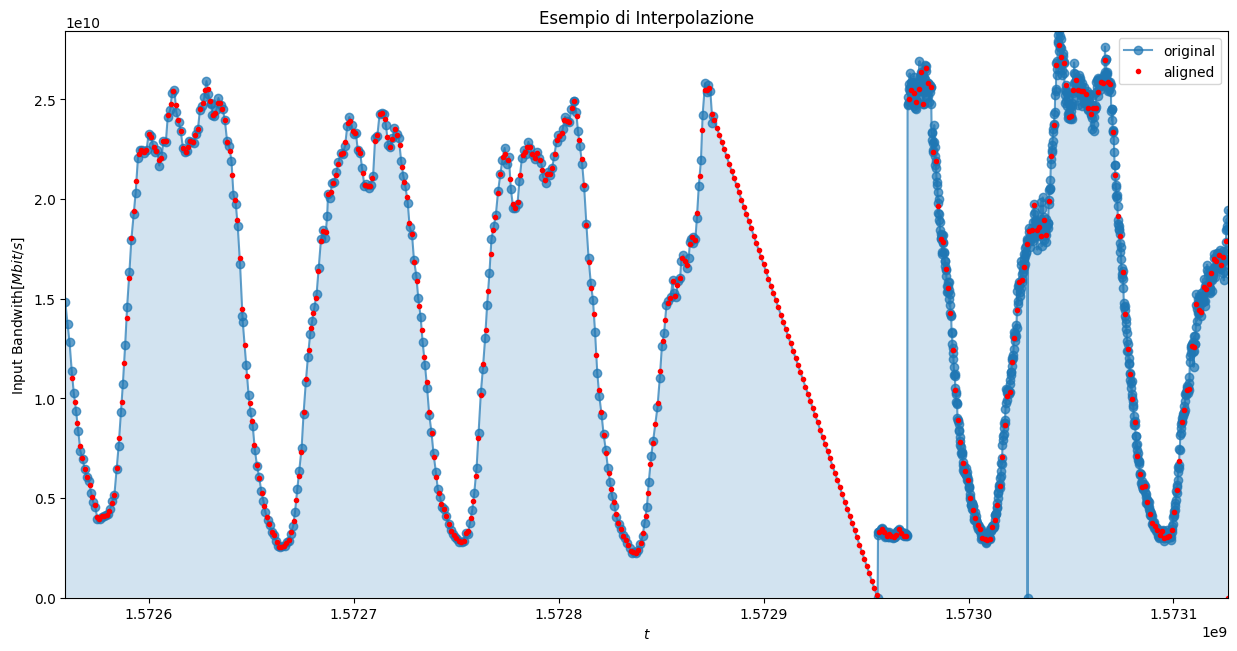

In [23]:
plt.figure(figsize=(15,7.5), dpi=100)
plt.plot(t[:,0], t[:,1], "-o", label="original", alpha=0.7)
plt.fill_between(t[:,0], 0, t[:,1], alpha=0.2)
plt.plot(tb, ta,".",label="aligned",color="red")
plt.legend()
plt.xlim(min(t[:,0])-0.5, max(t[:,0])+0.5)
plt.ylim(0, max(t[:,1])+0.5)
plt.xlabel('$t$')
plt.ylabel(r'Input Bandwith$[Mbit / s]$')
plt.title(r'Esempio di Interpolazione')
plt.show()

In [ ]:
np.mean(t[:,1])

In [ ]:
np.mean(ta)

In [ ]:
time = "2019-01-01"
datetime.strptime(time, "%Y-%m-%d").timestamp()

In [ ]:
1572562467.0 < 1569880800.0 < 1569880958.0